In [1]:
from flask import Flask, render_template, request, make_response
import pandas as pd
import geopandas as gpd
import json
from shapely.geometry import shape
import folium
from sqlalchemy import create_engine
import logging

## Importation des données :

1. Imprter les données sources avec les noms des EPCI (Aurélie)

In [2]:
data = pd.read_csv(r"C:\Users\gusta\Documents\Master GEEL\M2 GEEL\Python\Projet\INAT_NAT_EPCI_REGION.csv", sep=';')
#importer le fichier avec le nom des EPCI
epci=pd.read_excel(r"C:\Users\gusta\Documents\Master GEEL\M2 GEEL\Python\Projet\EPCI_au_01-01-2025.xlsx")
epci.head()
data['EPCI'] = data['EPCI'].astype(str)
epci['EPCI'] = epci['EPCI'].astype(str)
#jointure des deux dataframes pour avoir les noms des EPCI
data = epci[['EPCI', 'LIBEPCI']].merge(
    data, on='EPCI', how='left'
)
data=data.rename(columns={'LIBEPCI':'nom'})
data

C:\Users\gusta\AppData\Local\Temp\ipykernel_1400\2517776506.py:1: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"C:\Users\gusta\Documents\Master GEEL\M2 GEEL\Python\Projet\INAT_NAT_EPCI_REGION.csv", sep=';')


,EPCI,nom,INAT_BIS,NAT_rec3,total_s,num_dep,dep_name,region_name
0,200000172,Communauté de communes Faucigny-Glières,Etranger,Albanais,34.0,74,Haute-Savoie,Auvergne-Rhône-Alpes
1,200000172,Communauté de communes Faucigny-Glières,Etranger,Algériens,123.0,74,Haute-Savoie,Auvergne-Rhône-Alpes
2,200000172,Communauté de communes Faucigny-Glières,Etranger,Allemands,18.0,74,Haute-Savoie,Auvergne-Rhône-Alpes
3,200000172,Communauté de communes Faucigny-Glières,Etranger,Américains (U.S.),NaN,74,Haute-Savoie,Auvergne-Rhône-Alpes
4,200000172,Communauté de communes Faucigny-Glières,Etranger,Angolais,NaN,74,Haute-Savoie,Auvergne-Rhône-Alpes
...,...,...,...,...,...,...,...,...
172718,249740085,Communauté d'agglomération du Sud,NaN,NaN,NaN,NaN,NaN,NaN
172719,249740093,Communauté d'agglomération Intercommunale de l...,NaN,NaN,NaN,NaN,NaN,NaN
172720,249740101,Communauté d'agglomération Territoire de la Cô...,NaN,NaN,NaN,NaN,NaN,NaN
172721,249740119,Communauté d'agglomération Intercommunale du N...,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print(data['EPCI'].dtype)
print(epci['EPCI'].dtype)

object
object


2. Ajouter les données géographiques à partir du fichier json de Dina

In [3]:
#importer le json et le convertir
geo = pd.read_json(r"C:\Users\gusta\Documents\Master GEEL\M2 GEEL\Python\Projet\referents-contours-epci.json")
geo = geo.rename(columns={'geo_shape': 'geometry'})
geo["geometry"] = geo["geometry"].apply(lambda x: shape(json.loads(x)))
geo["geometry"] = geo["geometry"].apply(shape)

#créer le geodataframe
geo_epci = gpd.GeoDataFrame(geo, geometry="geometry", crs=4326)
geo_epci = geo_epci.rename(columns={'code_epci': 'EPCI'})
#affichage pour vérification
# geo_epci.plot()
# print(geo_epci.head())
geo_epci['EPCI'] = geo_epci['EPCI'].astype(str)
data['EPCI'] = data['EPCI'].astype(str)
#ajouter les coordonnées aux données
data_geo = geo_epci[['EPCI', 'geometry']].merge(data, on='EPCI', how='left')
data_geo.head()

#transformer total_s en numérique
data_geo['total_s'] = pd.to_numeric(data_geo['total_s'], errors='coerce')

#supprimer les doublons
data_geo = data_geo.sort_values(by='EPCI').drop_duplicates(subset=['EPCI', 'nom', 'NAT_rec3'])
data_geo = gpd.GeoDataFrame(
    data_geo, 
    geometry='geometry',  # colonne contenant les objets Shapely
    crs='EPSG:4326'       # définir le CRS si connu
)

<Axes: >

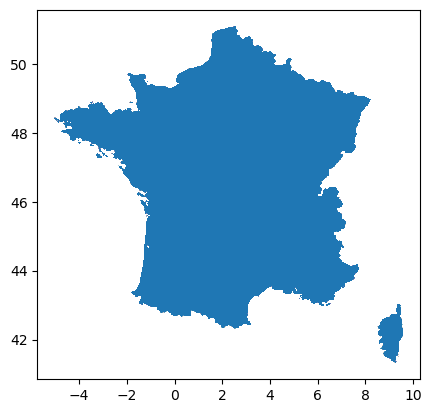

In [103]:
data_geo.plot()

## Création de la carte

1. Exploration de la création d'une carte follium pour une région

In [4]:
#filtrer les données pour la région normandie
# data_geo_normandie = data_geo[data_geo['region_name'] == 'Normandie']
data_geo_normandie = data_geo
data_geo_normandie

,EPCI,geometry,nom,INAT_BIS,NAT_rec3,total_s,num_dep,dep_name,region_name
82052,200000172,"POLYGON ((6.45518 46.05434, 6.45721 46.04366, ...",Communauté de communes Faucigny-Glières,Etranger,Sénégalais,33.0,74,Haute-Savoie,Auvergne-Rhône-Alpes
82076,200000172,"POLYGON ((6.45518 46.05434, 6.45721 46.04366, ...",Communauté de communes Faucigny-Glières,Français par acquisition,Belges,NaN,74,Haute-Savoie,Auvergne-Rhône-Alpes
82077,200000172,"POLYGON ((6.45518 46.05434, 6.45721 46.04366, ...",Communauté de communes Faucigny-Glières,Français par acquisition,Bosniaques,NaN,74,Haute-Savoie,Auvergne-Rhône-Alpes
82078,200000172,"POLYGON ((6.45518 46.05434, 6.45721 46.04366, ...",Communauté de communes Faucigny-Glières,Français par acquisition,Britanniques,NaN,74,Haute-Savoie,Auvergne-Rhône-Alpes
82020,200000172,"POLYGON ((6.45518 46.05434, 6.45721 46.04366, ...",Communauté de communes Faucigny-Glières,Etranger,Ivoiriens,NaN,74,Haute-Savoie,Auvergne-Rhône-Alpes
...,...,...,...,...,...,...,...,...,...
87888,249500513,"POLYGON ((1.73549 49.04874, 1.73186 49.05051, ...",Communauté de communes du Vexin-Val de Seine,Etranger,Thaïlandais,NaN,95,Val-d'Oise,Île-de-France
87928,249500513,"POLYGON ((1.73549 49.04874, 1.73186 49.05051, ...",Communauté de communes du Vexin-Val de Seine,Français par acquisition,Ethiopiens,NaN,95,Val-d'Oise,Île-de-France
87926,249500513,"POLYGON ((1.73549 49.04874, 1.73186 49.05051, ...",Communauté de communes du Vexin-Val de Seine,Français par acquisition,Equato-Guinéens,NaN,95,Val-d'Oise,Île-de-France
87916,249500513,"POLYGON ((1.73549 49.04874, 1.73186 49.05051, ...",Communauté de communes du Vexin-Val de Seine,Français par acquisition,Canadiens,NaN,95,Val-d'Oise,Île-de-France


In [ ]:
# convertir la géométrie en WKT (Excel ne supporte pas les objets shapely)
#data_geo["geometry"] = data_geo["geometry"].apply(lambda geom: geom.wkt)

# sauvegarder en Excel
#data_geo.to_excel("data_geo.xlsx", index=False)

C:\Users\gusta\AppData\Local\Temp\ipykernel_25544\145569556.py:2: UserWarning: Geometry column does not contain geometry.
  data_geo["geometry"] = data_geo["geometry"].apply(lambda geom: geom.wkt)


In [32]:
# # Calcul du nombre d'etrangers par EPCI en Normandie
# part_etranger_normandie = data_geo_normandie[data_geo_normandie['NAT_rec3'].isin(['etrangers', 'Tous'])]
# part_etranger_normandie = part_etranger_normandie.pivot_table(
#     index=['EPCI', 'nom', 'geometry'],  # colonnes qui restent fixes
#     columns='NAT_rec3',                # valeur unique par colonne
#     values='total_s'                  # colonne à mettre dans les nouvelles colonnes
# ).reset_index()
# part_etranger_normandie['Pct_Etranger'] = (part_etranger_normandie['etrangers'] / part_etranger_normandie['Tous']) * 100
# part_etranger_normandie

all_epci = data_geo_normandie[['EPCI', 'nom', 'geometry']].drop_duplicates()

pivot = data_geo_normandie[data_geo_normandie['NAT_rec3'].isin(['etrangers', 'Tous'])].pivot_table(
    index=['EPCI', 'nom', 'geometry'],
    columns='NAT_rec3',
    values='total_s',
    aggfunc='sum',
    fill_value=0
).reset_index()

part_etranger_normandie = all_epci.merge(
    pivot, on=['EPCI', 'nom', 'geometry'], how='left'
)

part_etranger_normandie['etrangers'] = part_etranger_normandie['etrangers'].fillna(0)
part_etranger_normandie['Tous'] = part_etranger_normandie['Tous'].fillna(0)

part_etranger_normandie['Pct_Etranger'] = (
    part_etranger_normandie['etrangers'] / part_etranger_normandie['Tous'] * 100
)

In [6]:
min_values = part_etranger_normandie['Tous'].min()
print("Minimums :\n", min_values)

Minimums :
 0.0


In [42]:
#Determiner les nationalités étrangeres les plus présentes par EPCI

#filtrer les données pour les nationalités étrangères
# etrangers_normandie = data_geo_normandie[data_geo_normandie['NAT_rec3']!='Français']


# etrangers_normandie = etrangers_normandie.sort_values(['EPCI', 'total_s'], ascending=[True, False])
# top3_per_epci = etrangers_normandie.groupby('EPCI').head(3).reset_index(drop=True)
# top3_per_epci['NAT_rec3'] = top3_per_epci['NAT_rec3'].fillna('').astype(str)
# top3_str = (
#     top3_per_epci
#     .groupby('EPCI')['NAT_rec3']
#     .apply(lambda x: ', '.join(x))
#     .reset_index()
# )
# top3_str = top3_str.rename(columns={'NAT_rec3': 'top3'})
# top3_str
# top3_str = top3_str.rename(columns={'top3': 'top3_nationalites'})  # nouveau nom

# 1️⃣ Filtrer uniquement les nationalités étrangères réelles
etrangers = data_geo_normandie[
    (data_geo_normandie['NAT_rec3'] != 'Français') &
    (data_geo_normandie['NAT_rec3'] != 'Tous') &
    (data_geo_normandie['NAT_rec3'] != 'immigres') &
    (data_geo_normandie['NAT_rec3'] != 'etrangers') &
    (data_geo_normandie['NAT_rec3'].notna())&
    (data_geo_normandie['INAT_BIS'] == 'Etranger')
]

# 2️⃣ Trier par total_s décroissant **à l’intérieur de chaque EPCI**
etrangers = etrangers.groupby('EPCI', group_keys=False).apply(
    lambda x: x.sort_values('total_s', ascending=False)
)

# 3️⃣ Prendre les 3 nationalités les plus représentées par EPCI
top3 = etrangers.groupby('EPCI').head(3).reset_index(drop=True)

top3_str = top3.merge(
    data_geo_normandie[['EPCI', 'region_name']].drop_duplicates(),
    on='EPCI',
    how='left'
)

# 4️⃣ Concaténer les nationalités en une seule chaîne
top3_str = (
    top3
    .groupby(['EPCI', 'region_name'])
    .apply(lambda g: ', '.join(g['NAT_rec3']))
    .reset_index(name='top3')
)

top3_str
#fusionner avec le dataframe des pourcentages
top3_str = top3_str.rename(columns={'top3': 'top3_nationalites'})

part_etranger_normandie = part_etranger_normandie.merge(
    top3_str,
    on='EPCI',
    how='left'  # garder tous les EPCI même s'il n'y a pas de top3
)
part_etranger_normandie['Pct_Etranger'] = part_etranger_normandie['Pct_Etranger'].round(1)
part_etranger_normandie['Pct_Etranger_str'] = part_etranger_normandie['Pct_Etranger'].astype(str) + '%'

part_etranger_normandie





C:\Users\gusta\AppData\Local\Temp\ipykernel_1400\3400778965.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  etrangers = etrangers.groupby('EPCI', group_keys=False).apply(
C:\Users\gusta\AppData\Local\Temp\ipykernel_1400\3400778965.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: ', '.join(g['NAT_rec3']))


,EPCI,nom,geometry,Tous,etrangers,Pct_Etranger,top3_nationalites_x,Pct_Etranger_str,top3_nationalites_y,region_name,top3_nationalites
0,200000172,Communauté de communes Faucigny-Glières,"POLYGON ((6.45518 46.05434, 6.45721 46.04366, ...",27764.0,2382.0,8.6,"Italiens, Suisses, Turcs",8.6%,"Italiens, Suisses, Turcs",Auvergne-Rhône-Alpes,"Italiens, Suisses, Turcs"
1,200000438,Communauté de communes du Pays de Pontchâteau ...,"POLYGON ((-1.98138 47.472, -1.97554 47.44632, ...",36232.0,311.0,0.9,"Bissao-Guinéens, Azerbaïdjanais, Albanais",0.9%,"Bissao-Guinéens, Azerbaïdjanais, Albanais",Pays de la Loire,"Bissao-Guinéens, Azerbaïdjanais, Albanais"
2,200000545,Communauté de communes des Portes de Romilly-s...,"POLYGON ((3.70283 48.47208, 3.681 48.46245, 3....",18866.0,2065.0,10.9,"Portugais, Tunisiens, Turcs",10.9%,"Portugais, Tunisiens, Turcs",Grand Est,"Portugais, Tunisiens, Turcs"
3,200000628,Communauté de communes Rhône Lez Provence,"POLYGON ((4.77878 44.2107, 4.76891 44.21081, 4...",24003.0,1626.0,6.8,"Algériens, Belges, Moldaves",6.8%,"Algériens, Belges, Moldaves",Provence-Alpes-Côte d'Azur,"Algériens, Belges, Moldaves"
4,200000800,Communauté de communes Cœur de Sologne,"POLYGON ((2.08771 47.58819, 2.08236 47.57924, ...",10310.0,278.0,2.7,"Italiens, Ivoiriens, Zaïrois",2.7%,"Italiens, Ivoiriens, Zaïrois",Centre-Val de Loire,"Italiens, Ivoiriens, Zaïrois"
...,...,...,...,...,...,...,...,...,...,...,...
1227,249500109,Communauté d'agglomération de Cergy-Pontoise,"POLYGON ((2.02496 48.99565, 2.0133 49.00127, 1...",214428.0,32802.0,15.3,"Marocains, Portugais, Maliens",15.3%,"Marocains, Portugais, Maliens",Île-de-France,"Marocains, Portugais, Maliens"
1228,249500430,Communauté de communes Sausseron Impressionnistes,"POLYGON ((2.09109 49.07226, 2.0877 49.07355, 2...",19061.0,825.0,4.3,"Dominicains, Equatoriens, Guinéens",4.3%,"Dominicains, Equatoriens, Guinéens",Île-de-France,"Dominicains, Equatoriens, Guinéens"
1229,249500455,Communauté de communes de la Vallée de l'Oise ...,"POLYGON ((2.27391 49.07659, 2.26939 49.07301, ...",39019.0,2959.0,7.6,"Algériens, Brésiliens, Chinois",7.6%,"Algériens, Brésiliens, Chinois",Île-de-France,"Algériens, Brésiliens, Chinois"
1230,249500489,Communauté de communes du Haut Val d'Oise,"POLYGON ((2.31344 49.12274, 2.30559 49.12027, ...",39726.0,5084.0,12.8,"Portugais, Marocains, Haïtiens",12.8%,"Portugais, Marocains, Haïtiens",Île-de-France,"Portugais, Marocains, Haïtiens"


In [34]:
top3_str

,EPCI,top3_nationalites
0,200000172,"Italiens, Suisses, Turcs"
1,200000438,"Bissao-Guinéens, Azerbaïdjanais, Albanais"
2,200000545,"Portugais, Tunisiens, Turcs"
3,200000628,"Algériens, Belges, Moldaves"
4,200000800,"Italiens, Ivoiriens, Zaïrois"
...,...,...
1219,249500109,"Marocains, Portugais, Maliens"
1220,249500430,"Dominicains, Equatoriens, Guinéens"
1221,249500455,"Algériens, Brésiliens, Chinois"
1222,249500489,"Portugais, Marocains, Haïtiens"


In [41]:
part_etranger_normandie


,EPCI,nom,geometry,Tous,etrangers,Pct_Etranger,top3_nationalites_x,Pct_Etranger_str,top3_nationalites_y
0,200000172,Communauté de communes Faucigny-Glières,"POLYGON ((6.45518 46.05434, 6.45721 46.04366, ...",27764.0,2382.0,8.6,"Italiens, Suisses, Turcs",8.6%,"Italiens, Suisses, Turcs"
1,200000438,Communauté de communes du Pays de Pontchâteau ...,"POLYGON ((-1.98138 47.472, -1.97554 47.44632, ...",36232.0,311.0,0.9,"Bissao-Guinéens, Azerbaïdjanais, Albanais",0.9%,"Bissao-Guinéens, Azerbaïdjanais, Albanais"
2,200000545,Communauté de communes des Portes de Romilly-s...,"POLYGON ((3.70283 48.47208, 3.681 48.46245, 3....",18866.0,2065.0,10.9,"Portugais, Tunisiens, Turcs",10.9%,"Portugais, Tunisiens, Turcs"
3,200000628,Communauté de communes Rhône Lez Provence,"POLYGON ((4.77878 44.2107, 4.76891 44.21081, 4...",24003.0,1626.0,6.8,"Algériens, Belges, Moldaves",6.8%,"Algériens, Belges, Moldaves"
4,200000800,Communauté de communes Cœur de Sologne,"POLYGON ((2.08771 47.58819, 2.08236 47.57924, ...",10310.0,278.0,2.7,"Italiens, Ivoiriens, Zaïrois",2.7%,"Italiens, Ivoiriens, Zaïrois"
...,...,...,...,...,...,...,...,...,...
1227,249500109,Communauté d'agglomération de Cergy-Pontoise,"POLYGON ((2.02496 48.99565, 2.0133 49.00127, 1...",214428.0,32802.0,15.3,"Marocains, Portugais, Maliens",15.3%,"Marocains, Portugais, Maliens"
1228,249500430,Communauté de communes Sausseron Impressionnistes,"POLYGON ((2.09109 49.07226, 2.0877 49.07355, 2...",19061.0,825.0,4.3,"Dominicains, Equatoriens, Guinéens",4.3%,"Dominicains, Equatoriens, Guinéens"
1229,249500455,Communauté de communes de la Vallée de l'Oise ...,"POLYGON ((2.27391 49.07659, 2.26939 49.07301, ...",39019.0,2959.0,7.6,"Algériens, Brésiliens, Chinois",7.6%,"Algériens, Brésiliens, Chinois"
1230,249500489,Communauté de communes du Haut Val d'Oise,"POLYGON ((2.31344 49.12274, 2.30559 49.12027, ...",39726.0,5084.0,12.8,"Portugais, Marocains, Haïtiens",12.8%,"Portugais, Marocains, Haïtiens"


In [43]:
import geopandas as gpd
import folium
import branca.colormap as cm

from shapely import wkt

gdf_normandie = gpd.GeoDataFrame(
    part_etranger_normandie,
    geometry='geometry',
    crs='EPSG:4326'
)
# 1️⃣ S'assurer que c'est un GeoDataFrame
gdf_normandie = gpd.GeoDataFrame(
    part_etranger_normandie, 
    geometry='geometry', 
    crs='EPSG:4326'
)

gdf_normandie['Pct_Etranger'] = gdf_normandie['Pct_Etranger'].fillna(0) 



# 2️⃣ Optionnel : simplifier la géométrie pour Folium (rapide)
gdf_normandie['geometry'] = gdf_normandie['geometry'].simplify(tolerance=0.001)

# 3️⃣ Créer une palette automatique
colormap = cm.linear.YlOrRd_09.scale(
    gdf_normandie['Pct_Etranger'].min(),
    gdf_normandie['Pct_Etranger'].max()
)
colormap.caption = "Pourcentage d'étrangers (%)"

# 4️⃣ Fonction de style
def style_function(feature):
    pct = feature['properties']['Pct_Etranger']
    return {
        'fillColor': colormap(pct),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7,
    }

# 5️⃣ Créer la carte
m = folium.Map(location=[49.0, 0.5], zoom_start=7)

# Ajouter les polygones
folium.GeoJson(
    gdf_normandie,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['nom', 'Pct_Etranger_str', 'top3_nationalites'],
        aliases=['EPCI:', 'Pct étrangers:', 'Nationalités étrangeres les plus présentes :'],
        localize=True
    )
).add_to(m)

# Ajouter la légende
colormap.add_to(m)

# 6️⃣ Afficher la carte
#m

m.save("carte_pct_etrangers_normandie.html")



In [130]:
print(type(part_etranger_normandie["geometry"].iloc[0]))


<class 'shapely.geometry.polygon.Polygon'>


Créer la page web avec menu déroulant :

In [ ]:
data_geo


In [44]:
#exporter données au format geojson
part_etranger_normandie = gpd.GeoDataFrame(
    part_etranger_normandie,
    geometry="geometry",
    crs="EPSG:4326"   # ou le CRS de tes données
)
part_etranger_normandie.to_file(r"C:\Users\gusta\Documents\Master GEEL\M2 GEEL\Python\Projet\data_etrangers.geojson", driver="GeoJSON")

In [45]:
data = gpd.read_file(r"C:\Users\gusta\Documents\Master GEEL\M2 GEEL\Python\Projet\data_etrangers.geojson")  # ou ton fichier
print(data.columns)

Index(['EPCI', 'nom', 'Tous', 'etrangers', 'Pct_Etranger',
       'top3_nationalites_x', 'Pct_Etranger_str', 'top3_nationalites_y',
       'region_name', 'top3_nationalites', 'geometry'],
      dtype='object')
